In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [2]:
sns.set_style('darkgrid')

In [3]:
# function to calculate the portfolio return
def portfolio_mu(weights, mu):
    return weights.T @ mu

In [4]:
# Function for computing standard deviation of portfolio returns
def portfolio_sd(weights, sigma):
    return np.sqrt(weights.T @ sigma @ weights)

In [5]:
# Return an array of equal weights that sum to one of dimension length
def get_equal_weights(length):
    return np.array([1 / length] * length)

In [6]:
# get data
df = pd.read_csv('../Data/20241010_data.csv', delimiter=";").dropna()
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')
# set date column as index
df.set_index('Date', inplace=True)
df.drop('UofM consumer sentiment', axis=1, inplace=True) # drop consumer confidence for now

df.drop('10y treasury Index', axis=1, inplace=True) # drop consumer confidence for now
ten_y_index = [100]
delta = -9.0/100.0
for i in range(len(df['10y'])-1):
    change_in_bp = (df['10y'][i+1] - df['10y'][i])/ df['10y'][i]
    ten_y_index.append(ten_y_index[i] + df['10y'][i]/(12) + change_in_bp * delta)

df['10y treasury Index'] = np.array(ten_y_index)


# split data in training and test set
split = 0.8
split_obs = int(df.shape[0] * split)
df_training = df[0:split_obs]
df_test = df[split_obs::]


# select data of all assets
data_all_assets_training = df_training[['SP500','Gold','3M-Index','10y treasury Index']].pct_change()
data_all_assets_test = df_test[['SP500','Gold','3M-Index','10y treasury Index']].pct_change()

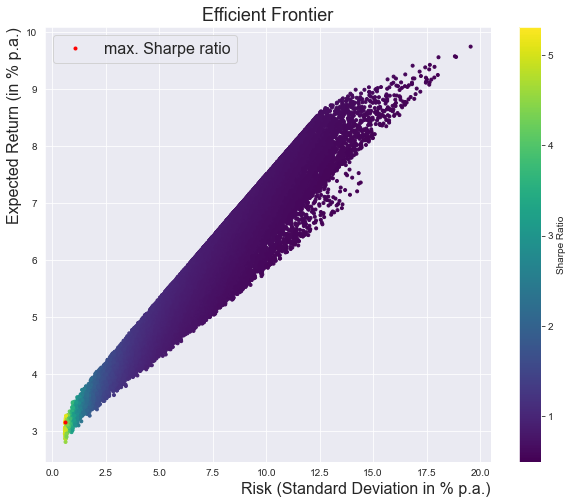

In [21]:
import warnings
# using colorbar causes a warning
warnings.filterwarnings("ignore")

# calculate the mean and the standard deviation of the trainings data
mu = data_all_assets_training.mean(axis=0).to_numpy() # adjust for monthly data
sigma = data_all_assets_training.cov().to_numpy()

# number of assets
n_assets = len(data_all_assets_training.columns)

# number of simulated portfolios
n_portfolios = 100000

# container to store results
portfolio_returns = []
portfolio_risks = []
portfolio_weights = []

max_sharpe_ratio = -np.inf

# simulate random portfolios
for _ in range(n_portfolios):
    # random weights
    weights = np.random.random(n_assets)
    weights /= np.sum(weights)  # normalize to sume to one
    
    # calc expected return of portfolio
    portfolio_return =  portfolio_mu(mu = mu, weights = weights) *12 # to get p.a. values
    
    # calc portfolio risk (std)
    portfolio_std_dev =  portfolio_sd(weights=weights, sigma=sigma) * np.sqrt(12)
    
    # store results
    portfolio_returns.append(portfolio_return)
    portfolio_risks.append(portfolio_std_dev)
    portfolio_weights.append(weights)

    if portfolio_return / portfolio_std_dev > max_sharpe_ratio:
        sharpe_return = portfolio_return
        sharpe_std = portfolio_std_dev
        max_sharpe_ratio = portfolio_return / portfolio_std_dev 
        max_sharpe_ratio_weights = weights

# drapproximate efficient frontier
portfolio_returns = np.array(portfolio_returns)
portfolio_risks = np.array(portfolio_risks)

plt.figure(figsize=(10, 8))
plt.scatter(portfolio_risks * 100, portfolio_returns *100, c=portfolio_returns/portfolio_risks, cmap='viridis', marker='.')
plt.colorbar(label='Sharpe Ratio')
plt.plot(sharpe_std *100, sharpe_return *100, '.', color='red', label='max. Sharpe ratio')
plt.xlabel('Risk (Standard Deviation in % p.a.)', loc='right',fontsize=16)
plt.ylabel('Expected Return (in % p.a.)', loc='top', fontsize=16)
plt.title('Efficient Frontier', fontsize=18)
plt.legend(fontsize=16)

plt.show()


In [11]:
max_sharpe_ratio_weights, sharpe_return, sharpe_std

(array([1.69447644e-04, 7.55541028e-03, 1.28899483e-01, 8.63375659e-01]),
 0.03162810087716748,
 0.005983826206820423)